#### Predicting future page visits with K Neares Neighbor
The idea is to implement K nearest neighbor algorithm found in paper: http://eps.upo.es/martinez/papers/HAIS16.pdf
And the algorithm can be illustrate with the paper figure below

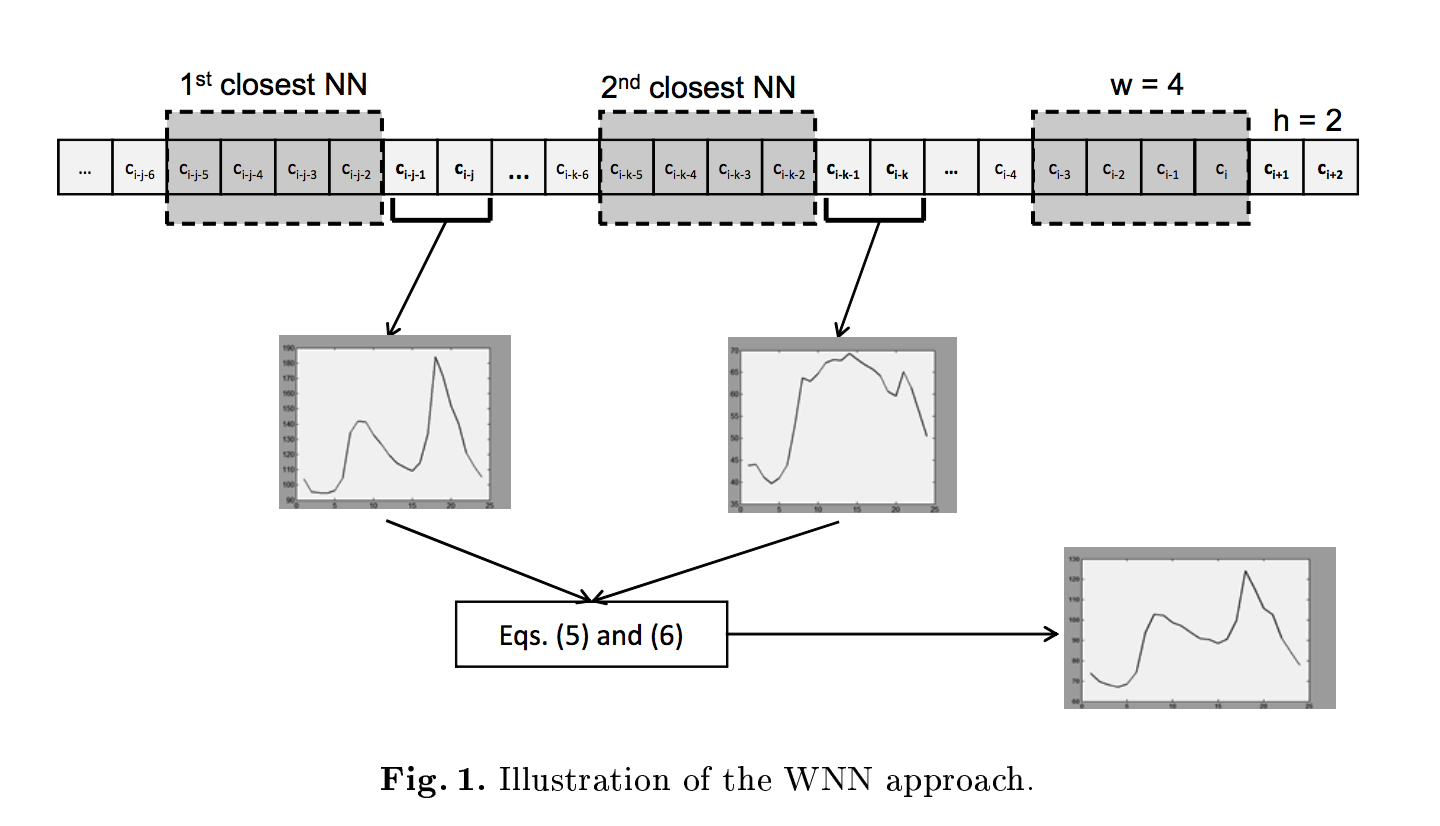

In [4]:
from IPython.display import Image
Image(filename="knn.png",width=600,height=400)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

##### Below codes were run on AWS with data stored on S3 bucket

In [2]:
import boto3, os
import io
from boto.s3.key import Key

ACCESS_KEY="key"
SECRET_KEY="key"

bucket='capstone0project2'
file_key = 'train_2.csv'

client = boto3.client(
    's3',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY)
# Get data from the AWS S3 bucket
response = client.get_object(Bucket=bucket, Key=file_key)
df = pd.read_csv(io.BytesIO(response['Body'].read()))

In [3]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


#### *Run on smaller pages*
Even with AWS service the memory is not enough to melt all the data, so will first run the KNN on smaller data

In [4]:
random_pages=df.sample(frac=0.0001,random_state=25)
print(random_pages.shape)
random_pages.head()

(15, 804)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
38022,Giant_oceanic_manta_ray_en.wikipedia.org_all-a...,340.0,398.0,337.0,466.0,409.0,620.0,621.0,584.0,463.0,...,265.0,263.0,284.0,261.0,246.0,281.0,372.0,267.0,266.0,267.0
8777,Charles_Dickens_en.wikipedia.org_desktop_all-a...,2220.0,2160.0,1848.0,1637.0,1837.0,2385.0,2560.0,2399.0,2223.0,...,2014.0,1571.0,1864.0,2239.0,2924.0,3385.0,3649.0,2735.0,2048.0,2577.0
8539,Anna_Faris_en.wikipedia.org_desktop_all-agents,4800.0,4505.0,4306.0,4515.0,4471.0,5185.0,4863.0,4573.0,4285.0,...,1822.0,1722.0,1826.0,1847.0,2307.0,2291.0,2301.0,1857.0,1861.0,1957.0
8199,Fête_du_Travail_fr.wikipedia.org_desktop_all-a...,82.0,61.0,66.0,62.0,57.0,92.0,74.0,121.0,66.0,...,418.0,189.0,321.0,857.0,323.0,173.0,141.0,83.0,51.0,84.0
47513,Last_Vegas_de.wikipedia.org_all-access_spider,2.0,0.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,...,2.0,3.0,3.0,3.0,3.0,1.0,2.0,2.0,4.0,3.0


In [5]:
train_flattened = pd.melt(random_pages, 
                          id_vars='Page', 
                          var_name='date', 
                          value_name='Visits')
train_flattened=train_flattened.sort_values(by=["Page","date"])
train_flattened=train_flattened.fillna(0)
train_flattened.head()

,Page,date,Visits
11,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-01,34.0
26,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-02,45.0
41,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-03,59.0
56,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-04,45.0
71,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-05,49.0


In [6]:
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')

# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

train_flattened.reset_index(drop=False,inplace=True)
print(train_flattened.shape)# 803 days for 1453 pages
train_flattened.head() 

(12045, 7)


,Page,date,Visits,mean,median,weekend,weekday
0,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-01,34.0,128.028643,39.0,0.0,2
1,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-02,45.0,128.028643,39.0,0.0,3
2,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-03,59.0,128.028643,39.0,0.0,4
3,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-04,45.0,128.028643,39.0,1.0,5
4,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-05,49.0,128.028643,39.0,1.0,6


In [7]:
lag_days=[1,2,3,4,5,6,7]
temp_list=[]

for lag in lag_days:
    temp_serial = train_flattened["Visits"].shift(periods=lag)
    temp_df=pd.DataFrame(temp_serial)
    temp_df.rename(columns={"Visits":lag},inplace=True)
    temp_list.append(temp_df)
    lagged_df=pd.concat(temp_list, axis=1)
train_lagged=pd.concat([train_flattened,lagged_df],axis=1)
train_lagged.head()

,Page,date,Visits,mean,median,weekend,weekday,1,2,3,4,5,6,7
0,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-01,34.0,128.028643,39.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-02,45.0,128.028643,39.0,0.0,3,34.0,NaN,NaN,NaN,NaN,NaN,NaN
2,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-03,59.0,128.028643,39.0,0.0,4,45.0,34.0,NaN,NaN,NaN,NaN,NaN
3,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-04,45.0,128.028643,39.0,1.0,5,59.0,45.0,34.0,NaN,NaN,NaN,NaN
4,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-05,49.0,128.028643,39.0,1.0,6,45.0,59.0,45.0,34.0,NaN,NaN,NaN


In [8]:
test_start_date="2017-07-04" # 7 days back
test_end_date="2017-09-10"
mask = (train_lagged['date'] >= test_start_date) & (train_lagged['date'] <= test_end_date)
test_df=train_lagged[mask]
true=test_df["Visits"]
alias_df=train_lagged[mask]
test_df.head()

,Page,date,Visits,mean,median,weekend,weekday,1,2,3,4,5,6,7
734,8月16日_ja.wikipedia.org_desktop_all-agents,2017-07-04,48.0,128.028643,39.0,0.0,1,50.0,39.0,36.0,38.0,77.0,50.0,32.0
735,8月16日_ja.wikipedia.org_desktop_all-agents,2017-07-05,52.0,128.028643,39.0,0.0,2,48.0,50.0,39.0,36.0,38.0,77.0,50.0
736,8月16日_ja.wikipedia.org_desktop_all-agents,2017-07-06,70.0,128.028643,39.0,0.0,3,52.0,48.0,50.0,39.0,36.0,38.0,77.0
737,8月16日_ja.wikipedia.org_desktop_all-agents,2017-07-07,68.0,128.028643,39.0,0.0,4,70.0,52.0,48.0,50.0,39.0,36.0,38.0
738,8月16日_ja.wikipedia.org_desktop_all-agents,2017-07-08,78.0,128.028643,39.0,1.0,5,68.0,70.0,52.0,48.0,50.0,39.0,36.0


In [9]:
train_start_date="2015-07-08" # 2015-07-01 ~ 07 has Nan values of lagged days
train_end_date="2017-07-11"
mask_t = (train_lagged['date'] >= train_start_date) & (train_lagged['date'] < train_end_date)

train_df=train_lagged[mask_t]
#train_df[lag_col]=train_df[lag_col].apply(np.log10)
#train_df=train_df.drop(columns="Unnamed: 0")
train_df.head()

,Page,date,Visits,mean,median,weekend,weekday,1,2,3,4,5,6,7
7,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-08,110.0,128.028643,39.0,0.0,2,57.0,72.0,49.0,45.0,59.0,45.0,34.0
8,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-09,70.0,128.028643,39.0,0.0,3,110.0,57.0,72.0,49.0,45.0,59.0,45.0
9,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-10,78.0,128.028643,39.0,0.0,4,70.0,110.0,57.0,72.0,49.0,45.0,59.0
10,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-11,68.0,128.028643,39.0,1.0,5,78.0,70.0,110.0,57.0,72.0,49.0,45.0
11,8月16日_ja.wikipedia.org_desktop_all-agents,2015-07-12,65.0,128.028643,39.0,1.0,6,68.0,78.0,70.0,110.0,57.0,72.0,49.0


In [10]:
from sklearn.neighbors import NearestNeighbors

X_train=np.array(train_df.iloc[:,3:])
y_train=np.array(train_df.iloc[:,2]).reshape(-1,1)

In [11]:
neigh_1 = NearestNeighbors(n_neighbors=10)
neigh_1.fit(X_train) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
i=0
j=0
while j < test_df.shape[0]:
    ''' Iterate predictions into features '''
    # get features of each page for each day
    pred_start_date="2017-07-11" 
    mask = (test_df['date'] >= pred_start_date)
    df=test_df[mask]
    X_test=np.array(df.iloc[i,3:]).reshape(1,-1)
    
    # find 10 nearest neighbors and get their median
    tuple_1=neigh_1.kneighbors(X_test)
    index_10=tuple_1[1].tolist()[0]
    array_10=y_train[index_10].reshape(1,-1)[0]
    median=np.median(array_10)
    if i in [0,1,5,100,1000, 5000,10000]:
        print(median)
    # replace the cell with the predicted value

    if j%69==0:
        j=j+7
        
    test_df.iloc[j,2]=median
                   
    lag_days=[1,2,3,4,5,6,7]
    for lag in lag_days:
        temp_serial = test_df["Visits"].shift(periods=lag)
        temp_df=pd.DataFrame(temp_serial)
        temp_df.rename(columns={"Visits":lag},inplace=True)
        test_df[lag]=temp_df
        test_df.iloc[0:7,:]=alias_df.iloc[0:7,:]
    
    i=i+1
    j=j+1

61.0
60.0
55.5
